In [343]:
# assessment data: WHO global air quality guidelines
# link: https://www.eea.europa.eu/publications/status-of-air-quality-in-Europe-2022/europes-air-quality-status-2022/world-health-organization-who-air

# *data: https://powietrze.gios.gov.pl/pjp/current/station_details/archive/402
# for October 2023 Krakow - ul. Bulwarowa
# * in exported csv, CO values are in mg/m3 not ug/m3

In [344]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [345]:
pm10_safe_limit = 45  # 24h -> ug/m3
pm25_safe_limit = 15  # 24h -> ug/m3
no2_safe_limit = 200  # 24h -> ug/m3
so2_safe_limit = 500  # 24h -> ug/m3
co_safe_limit = 4     # 24h -> mg/m3


In [346]:
# create df
column_names = ["Date Time", "PM10", "PM25", "NO2", "SO2", "CO"]
df = pd.read_csv("gios-pjp-data.csv", sep=",", skiprows=1, header=None)
df = df.iloc[:, :-1]
df.columns = column_names
df[column_names[1:]] = df[column_names[1:]].replace(r"^\s*$", np.nan, regex=True)
df = df.dropna()
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%Y-%m-%d %H:%M")
df["PM10"] = df["PM10"].astype(float)
df["PM25"] = df["PM25"].astype(float)
df["NO2"] = df["NO2"].astype(float)
df["SO2"] = df["SO2"].astype(float)
df["CO"] = df["CO"].astype(float)

In [347]:
df_daily = df.groupby(df["Date Time"].dt.date).mean()
df_daily.head()

,Date Time,PM10,PM25,NO2,SO2,CO
Date Time,,,,,,
2023-10-01,2023-10-01 13:12:00,16.740000,21.940000,19.460000,2.785000,0.240000
2023-10-02,2023-10-02 11:30:00,13.354167,21.429167,21.900000,2.575000,0.275000
2023-10-03,2023-10-03 11:30:00,19.045833,32.379167,22.808333,2.491667,0.266667
2023-10-04,2023-10-04 11:30:00,7.954167,13.045833,23.908333,2.066667,0.141667
2023-10-05,2023-10-05 11:30:00,14.362500,20.766667,25.650000,2.645833,0.204167


In [348]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 2023-10-01 to 2023-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date Time  32 non-null     datetime64[ns]
 1   PM10       32 non-null     float64       
 2   PM25       32 non-null     float64       
 3   NO2        32 non-null     float64       
 4   SO2        32 non-null     float64       
 5   CO         32 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.8+ KB


In [349]:
df_daily.describe()

,Date Time,PM10,PM25,NO2,SO2,CO
count,32,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2023-10-16 23:19:39.642857216,18.582463,26.692005,20.551503,3.394509,0.265945
min,2023-10-01 13:12:00,5.523810,7.919048,9.700000,2.066667,0.085714
25%,2023-10-09 05:46:04.285714432,11.996875,16.701190,18.082292,2.640625,0.178125
50%,2023-10-16 23:30:00,17.488750,23.363750,21.727083,3.150595,0.226250
75%,2023-10-24 17:30:00,21.447917,36.231250,23.931250,3.926190,0.327232
max,2023-11-01 00:00:00,45.554167,57.054167,27.104167,5.862500,0.504167
std,NaN,9.347978,12.910223,4.462513,0.890009,0.117086


In [350]:
pm10_max = df_daily["PM10"].max() if df_daily["PM10"].max() > pm10_safe_limit else pm10_safe_limit
pm25_max = df_daily["PM25"].max() if df_daily["PM25"].max() > pm25_safe_limit else pm25_safe_limit
no2_max = df_daily["NO2"].max() if df_daily["NO2"].max() > no2_safe_limit else no2_safe_limit
so2_max = df_daily["SO2"].max() if df_daily["SO2"].max() > so2_safe_limit else so2_safe_limit
co_max = df_daily["CO"].max() if df_daily["CO"].max() > co_safe_limit else co_safe_limit

In [351]:
step_size = 0.01

pm10 = ctrl.Antecedent(np.arange(0, pm10_max + step_size, step_size), "pm10")
pm25 = ctrl.Antecedent(np.arange(0, pm25_max + step_size, step_size), "pm25")
no2 = ctrl.Antecedent(np.arange(0, no2_max + step_size, step_size), "no2")
so2 = ctrl.Antecedent(np.arange(0, so2_max + step_size, step_size), "so2")
co = ctrl.Antecedent(np.arange(0, co_max + step_size, step_size), "co")
air_quality = ctrl.Consequent(np.arange(0, 2 + step_size, step_size), "air_quality", defuzzify_method="centroid") #bisection, mom, lom

good = "good"
moderate = "moderate"
unhealthy = "unhealthy"

c:\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


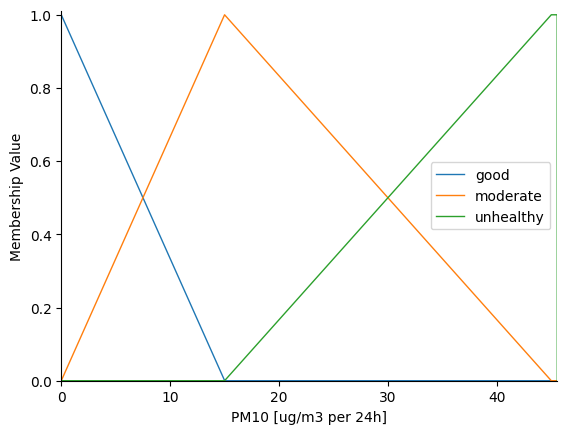

In [352]:
pm10[good] = fuzz.trimf(pm10.universe, [0, 0, pm10_safe_limit / 3])
pm10[moderate] = fuzz.trimf(pm10.universe, [0, pm10_safe_limit / 3, pm10_safe_limit])
pm10[unhealthy] = fuzz.trapmf(pm10.universe, [pm10_safe_limit / 3, pm10_safe_limit, pm10_max, pm10_max])
pm10.view()

plt.xlabel("PM10 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

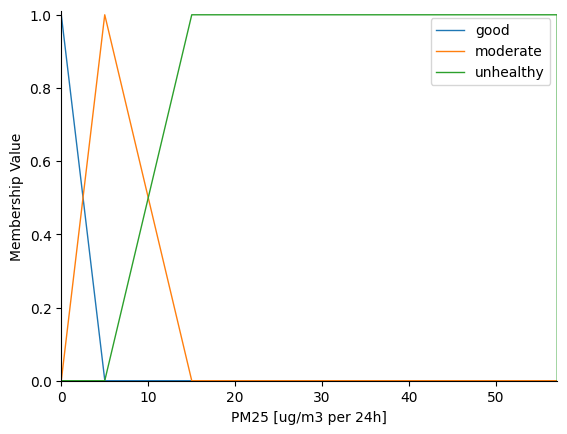

In [353]:
pm25[good] = fuzz.trimf(pm25.universe, [0, 0, pm25_safe_limit / 3])
pm25[moderate] = fuzz.trimf(pm25.universe, [0, pm25_safe_limit / 3, pm25_safe_limit])
pm25[unhealthy] = fuzz.trapmf(pm25.universe, [pm25_safe_limit / 3, pm25_safe_limit, pm25_max, pm25_max])
pm25.view()

plt.xlabel("PM25 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

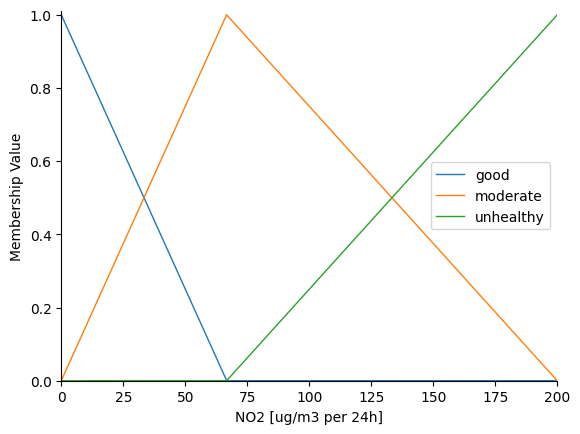

In [354]:
no2[good] = fuzz.trimf(no2.universe, [0, 0, no2_safe_limit / 3])
no2[moderate] = fuzz.trimf(no2.universe, [0, no2_safe_limit / 3, no2_safe_limit])
no2[unhealthy] = fuzz.trapmf(no2.universe, [no2_safe_limit / 3, no2_safe_limit, no2_max, no2_max])
no2.view()

plt.xlabel("NO2 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

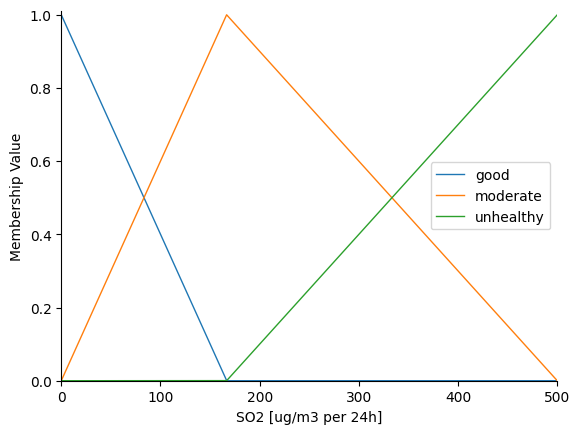

In [355]:
so2[good] = fuzz.trimf(so2.universe, [0, 0, so2_safe_limit / 3])
so2[moderate] = fuzz.trimf(so2.universe, [0, so2_safe_limit / 3, so2_safe_limit])
so2[unhealthy] = fuzz.trapmf(so2.universe, [so2_safe_limit / 3, so2_safe_limit, so2_max, so2_max])
so2.view()

plt.xlabel("SO2 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

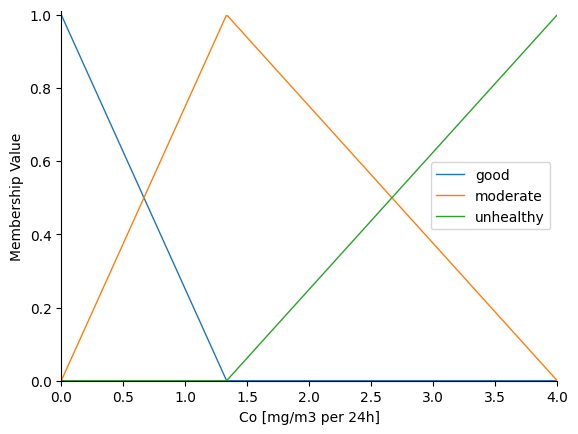

In [356]:
co[good] = fuzz.trimf(co.universe, [0, 0, co_safe_limit / 3])
co[moderate] = fuzz.trimf(co.universe, [0, co_safe_limit / 3, co_safe_limit])
co[unhealthy] = fuzz.trapmf(co.universe, [co_safe_limit / 3, co_safe_limit, co_max, co_max])
co.view()

plt.xlabel("Co [mg/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

c:\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


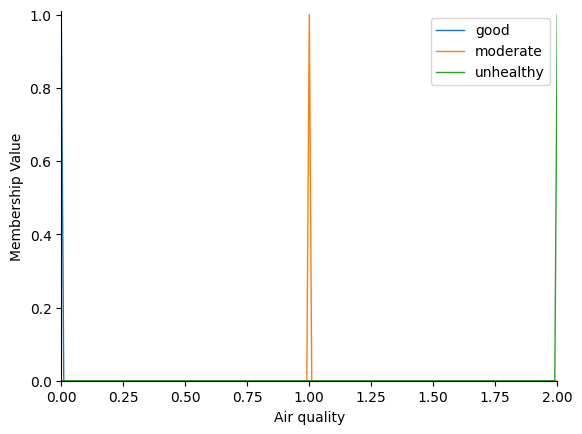

In [358]:
air_quality[good] = fuzz.trimf(air_quality.universe, [0, 0, 0])
air_quality[moderate] = fuzz.trimf(air_quality.universe, [1, 1, 1])
air_quality[unhealthy] = fuzz.trimf(air_quality.universe, [2, 2, 2])
air_quality.view()

plt.xlabel("Air quality")
plt.ylabel("Membership Value")
plt.legend()
plt.show()